In [96]:
import os 
import re 
import ast
import random 
from math import floor, log as ln
from abc import ABC, abstractmethod
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 


MAIN_PATH = os.path.join("/Users", "jcheigh", "Thesis")
DATA_PATH = os.path.join(MAIN_PATH, "data")
PLOT_PATH = os.path.join(MAIN_PATH, "plots")
RES_PATH  = os.path.join(MAIN_PATH, "results")

PLOT_PATHS = {
    "error plots"     : f"{PLOT_PATH}/error plots/"
    }

PLOT_NAME  = {
    "error plots"     : r"p = (?P<prime>\d+) error plot.jpg"
    }

PLOT_PARAMS = {
    "error plots"     : ("prime")
    }

CSV_PATHS = {
    "raw error"       : f"{DATA_PATH}/raw_error.csv",
    "processed_error" : f"{DATA_PATH}/processed_error.csv"
    }

EXP_PATHS = {
    "character sum"   : f"{DATA_PATH}/char sum lists/",
    "polya fourier"   : f"{DATA_PATH}/polya fourier lists/",
    "symmetry"        : f"{DATA_PATH}/symmetry/",
    "leg fixed n"     : f"{DATA_PATH}/legendre fixed n/",
    "error lists"     : f"{DATA_PATH}/error lists/"
    } #    "antisymmetry"  : f"{DATA_PATH}/antisymmetry/"

EXP_NAME = {
    "symmetry"        : r"symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    "polya fourier"   : r"p = (?P<prime>\d+) fourier exp list",
    "character sum"   : r"p = (?P<prime>\d+) character sum list",
    "leg fixed n"     : r"n = (?P<n>\d+) legendre symbol list",
    "error lists"     : r"p = (?P<prime>\d+) error list",
    } #    "antisymmetry"  : r"FILL IN",

EXP_PARAMS = {
    "symmetry"        : ('prime', 'delta'),
    "polya fourier"   : ("prime"),
    "character sum"   : ("prime"),
    "leg fixed n"     : ('n'),
    "error lists"     : ("prime")
    } #    "antisymmetry"  : ('prime', 'delta'),

def process(lst):
    processed_lst = []  

    for item in lst:
        # If the item starts with a '(', consider it a tuple
        if item.startswith('('):
            try:
                # Safely evaluate the item as a tuple
                processed_tuple = ast.literal_eval(item)
                processed_lst.append(processed_tuple)
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)
        else:
            try:
                # Convert the item to a float
                processed_lst.append(float(item))
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)

    return processed_lst

def fetch_data(experiment):
    ### Usage: fetch_data('polya fourier')
    path   = EXP_PATHS[experiment]  # f"{DATA_PATH}/symmetry/",
    name   = EXP_NAME[experiment]   # symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    params = EXP_PARAMS[experiment] # (prime, delta)
    
    data = {}
    for filename in os.listdir(path):
        # Match the filename with the regex pattern
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            # Read the file and get the list of elements
            with open(os.path.join(path, filename), 'r') as file:
                elements = [line.strip() for line in file.readlines()]

            elements = process(elements)
            # Update the global dictionary
            data[key] = elements

    return data 

def read_csv(name):
    ### Usage: read_csv('processed_error')
    return pd.read_csv(CSV_PATHS[name])

def get_plot_dict(name):
    ### returns {105601 : "/Users/jcheigh/Thesis/..."}
    path   = PLOT_PATHS[name]
    params = PLOT_PARAMS[name]
    name   = PLOT_NAME[name]

    result = {}
    for filename in os.listdir(path):
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            result[key] = os.path.join(path, filename)
    
    return result

def plot(name, params=None, N=1):
    # plot('error plots', [(199693)]
    path_map = get_plot_dict(name)
    
    if params:
        # use params
        paths = [path_map[param] for param in params]

    else:
        # or random N
        paths = random.choices(list(path_map.values()), k=N)

    for path in paths:
        try:
            img = Image.open(path)
            plt.figure(figsize = (20,10))
            plt.imshow(img)
            plt.axis('off')  # Turn off axis
            plt.show()
        except Exception:
            print(f"Plot failed")

class Saver(ABC):
    
    @property
    @abstractmethod
    def path(self):
        """Abstract property for the path where files should be saved."""
        raise NotImplementedError

    @property
    @abstractmethod 
    def type(self):
        """Abstract property for data type: one of (plot, df, list)"""
        raise NotImplementedError

    @abstractmethod
    def get_name(self, params):
        """Abstract method to generate the filename based on the parameters."""
        raise NotImplementedError
    
    def __init__(self):
        # Check if path exists, and create it if it doesn't
        if not os.path.exists(self.path):
            os.makedirs(self.path)
    
    def _get_full_path(self, name, extension):
        """Construct the full path."""
        return os.path.join(self.path, f"{name}.{extension}")

    def _check_overwrite(self, path):
        """Check if file exists and handle overwriting."""
        if os.path.exists(path):
            print(f"Overwriting {path}")
            with open(path, 'r') as f:
                original_data = f.read()
            return original_data
        return None

    def _save_data(self, params, data):
        """Save data to the specified path."""
        name = self.get_name(params)
        
        if self.type == "df":
            # Save DataFrame to .csv
            path = self._get_full_path(name, "csv")
            data.to_csv(path, index=False)
            return None

        elif self.type == "list":
            # Save list to .txt
            path = self._get_full_path(name, "txt")
            original_data = self._check_overwrite(path)
            with open(path, 'w') as f:
                for item in data:
                    f.write(f"{item}\n")
            return original_data

        elif self.type == 'plot':
            # Save plt object to .jpg
            path = self._get_full_path(name, "jpg")
            data.savefig(path)
            return None

        else:
            raise TypeError("Unsupported data type for saving.")

    def save(self, params, data):
        return self._save_data(params, data)

def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (10,8))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title = None, savefig = False, savename = None):
    # distribution of categorical
    plt.figure(figsize = (10,8))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title = None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (10, 8))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(30, 20))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p


In [3]:
class ErrorListSaver(Saver):
    path = f'{DATA_PATH}/error lists/'
    type = 'list'

    def get_name(self, params):
        if isinstance(params, tuple):
            prime = params[0]
        elif isinstance(params, int):
            prime = params
        else:
            raise TypeError("params should be a tuple or an integer")

        return f"p = {prime} error list"


In [6]:
error_lsts = fetch_data('error lists')

In [4]:
### fetch data
fourier_data  = fetch_data("polya fourier")
char_sum_data = fetch_data("character sum")

In [8]:
def update_error_lst():
    overlap = list(set(fourier_data.keys()).intersection(set(char_sum_data.keys())))
    saver   = ErrorListSaver()

    for prime in overlap:
        fourier   = np.array(fourier_data[prime])
        char_sum  = np.array(char_sum_data[prime])
        error_lst = char_sum - fourier
        saver.save(prime, error_lst)

In [9]:
error_data = fetch_data("error lists")

In [29]:
def partition_mod4():
    one = [prime for prime in error_data.keys() if prime % 4 == 1]
    three = [prime for prime in error_data.keys() if prime % 4 == 3]
    return {1: one, 3 : three}

def get_means():
    partition = partition_mod4()
    results = {}
    for prime in partition[1]:
        data = error_data[prime]
        print('=' * 20)
        mean = np.mean(data)
        std_dev = np.std(data)
        results[prime] = (1, mean, std_dev)
        print(f"Prime = {prime}, 1 mod 4, mean = {mean}, std dev = {std_dev}")

    for prime in partition[3]:
        data = error_data[prime]
        print('=' * 20)
        mean = np.mean(data)
        std_dev = np.std(data)
        results[prime] = (3, mean, std_dev)
        print(f"Prime = {prime}, 3 mod 4, mean = {mean}, std dev = {std_dev}")

    return results

results = get_means()

Prime = 141269, 1 mod 4, mean = 1.6095086356046412e-18, std dev = 7.137085374598465
Prime = 113149, 1 mod 4, mean = -6.731847499622863e-17, std dev = 6.504170150559251
Prime = 122021, 1 mod 4, mean = -5.590193707064326e-18, std dev = 6.705048406836319
Prime = 117709, 1 mod 4, mean = -5.7949776680601835e-18, std dev = 6.609606331706121
Prime = 125693, 1 mod 4, mean = -1.3069739803150148e-16, std dev = 6.805187094673613
Prime = 129749, 1 mod 4, mean = -1.577170597838202e-17, std dev = 6.889123804578599
Prime = 195457, 1 mod 4, mean = -1.3494193787592627e-16, std dev = 8.165777026654704
Prime = 117673, 1 mod 4, mean = -3.0916002881644155e-17, std dev = 6.608585485649126
Prime = 192529, 1 mod 4, mean = -5.904920179381601e-17, std dev = 8.104383904250582
Prime = 196993, 1 mod 4, mean = 6.290510480908533e-17, std dev = 8.197799400419314
Prime = 1020389, 1 mod 4, mean = 6.996874142035524e-17, std dev = 16.429832141712446
Prime = 108529, 1 mod 4, mean = 2.514059933583452e-17, std dev = 6.39363

All 1 mod 4 have mean 0 (~10e-17+=1), whereas all 3 mod 4 have mean nonzero. Further, the very large primes (~1 million) are indistinguishable.

However, standard deviation seems to grow in a pretty predictable way with size of prime (~6-8 for 100000-200000 and ~16.3-16.4 for 1 million).

### In Depth Analysis: <br>
- p = 196993 (1 mod 4)

In [24]:
prime        = 196993
error_lst    = error_data[prime]
fourier_lst  = fourier_data[prime]
char_sum_lst = char_sum_data[prime]

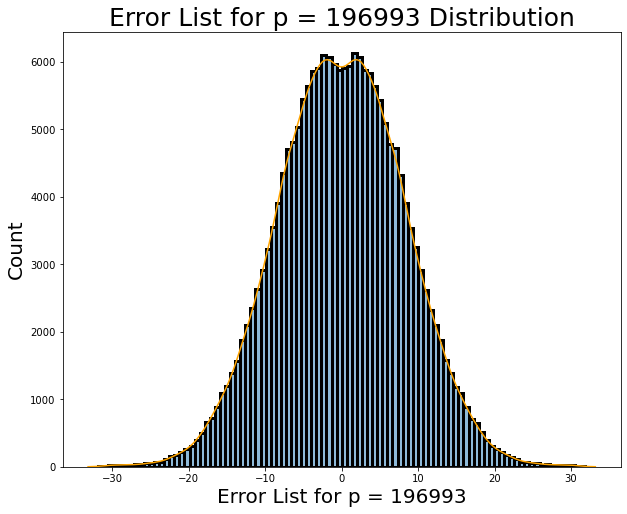

<AxesSubplot:title={'center':'Error List for p = 196993 Distribution'}, xlabel='Error List for p = 196993', ylabel='Count'>

In [26]:
histplot(error_lst, bins= 100, xlabel = f"Error List for p = {prime}")

Seems normal like. An ambitious yet realistic conjecture would be that the distribution of the error list converges to a Gaussian. In the case where p is 1 mod 4, this Gaussian has mean 0 and standard deviation a monotonic function of p. I think the standard deviation should be something like a linear function of sqrt(p), though this isn't exactly right.

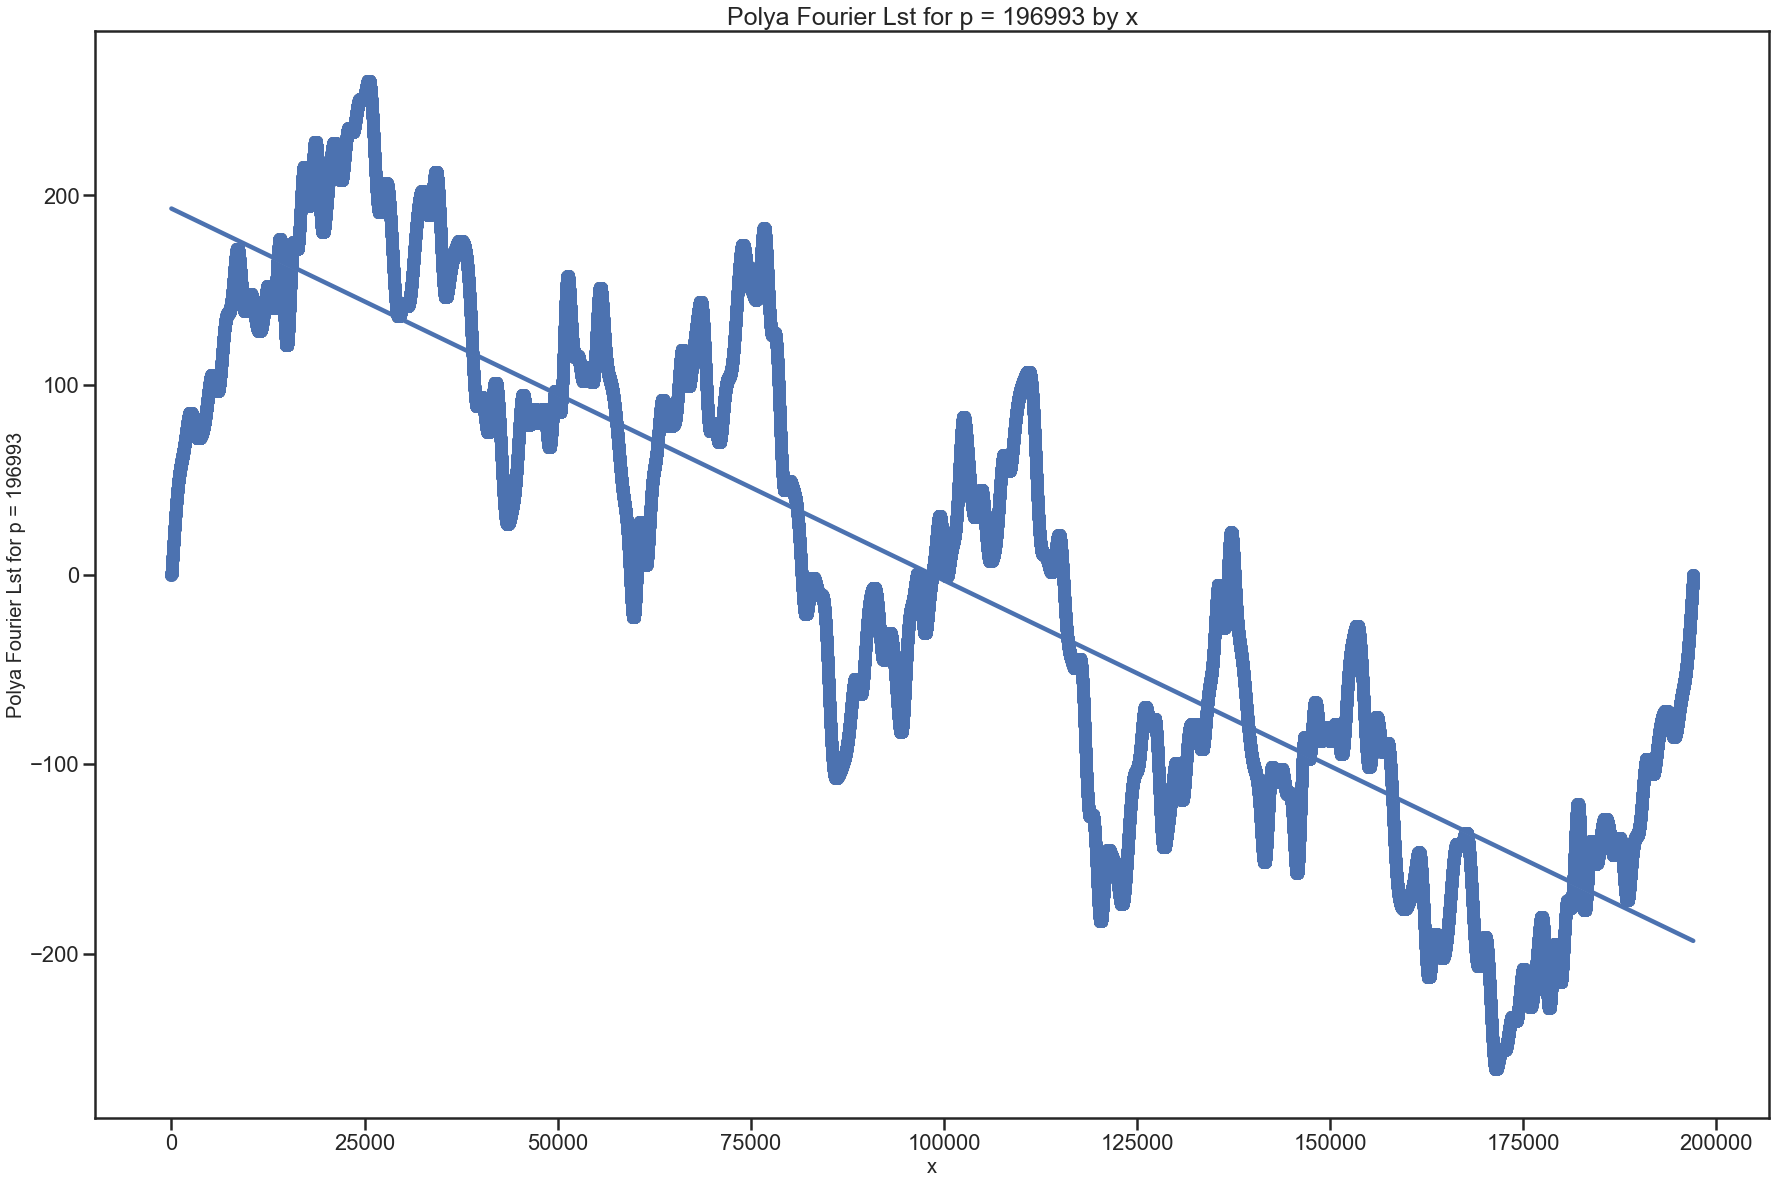

<AxesSubplot:title={'center':'Polya Fourier Lst for p = 196993 by x'}, xlabel='x', ylabel='Polya Fourier Lst for p = 196993'>

In [100]:
scatter(list(range(196993)), fourier_lst, "x", f"Polya Fourier Lst for p = 196993")

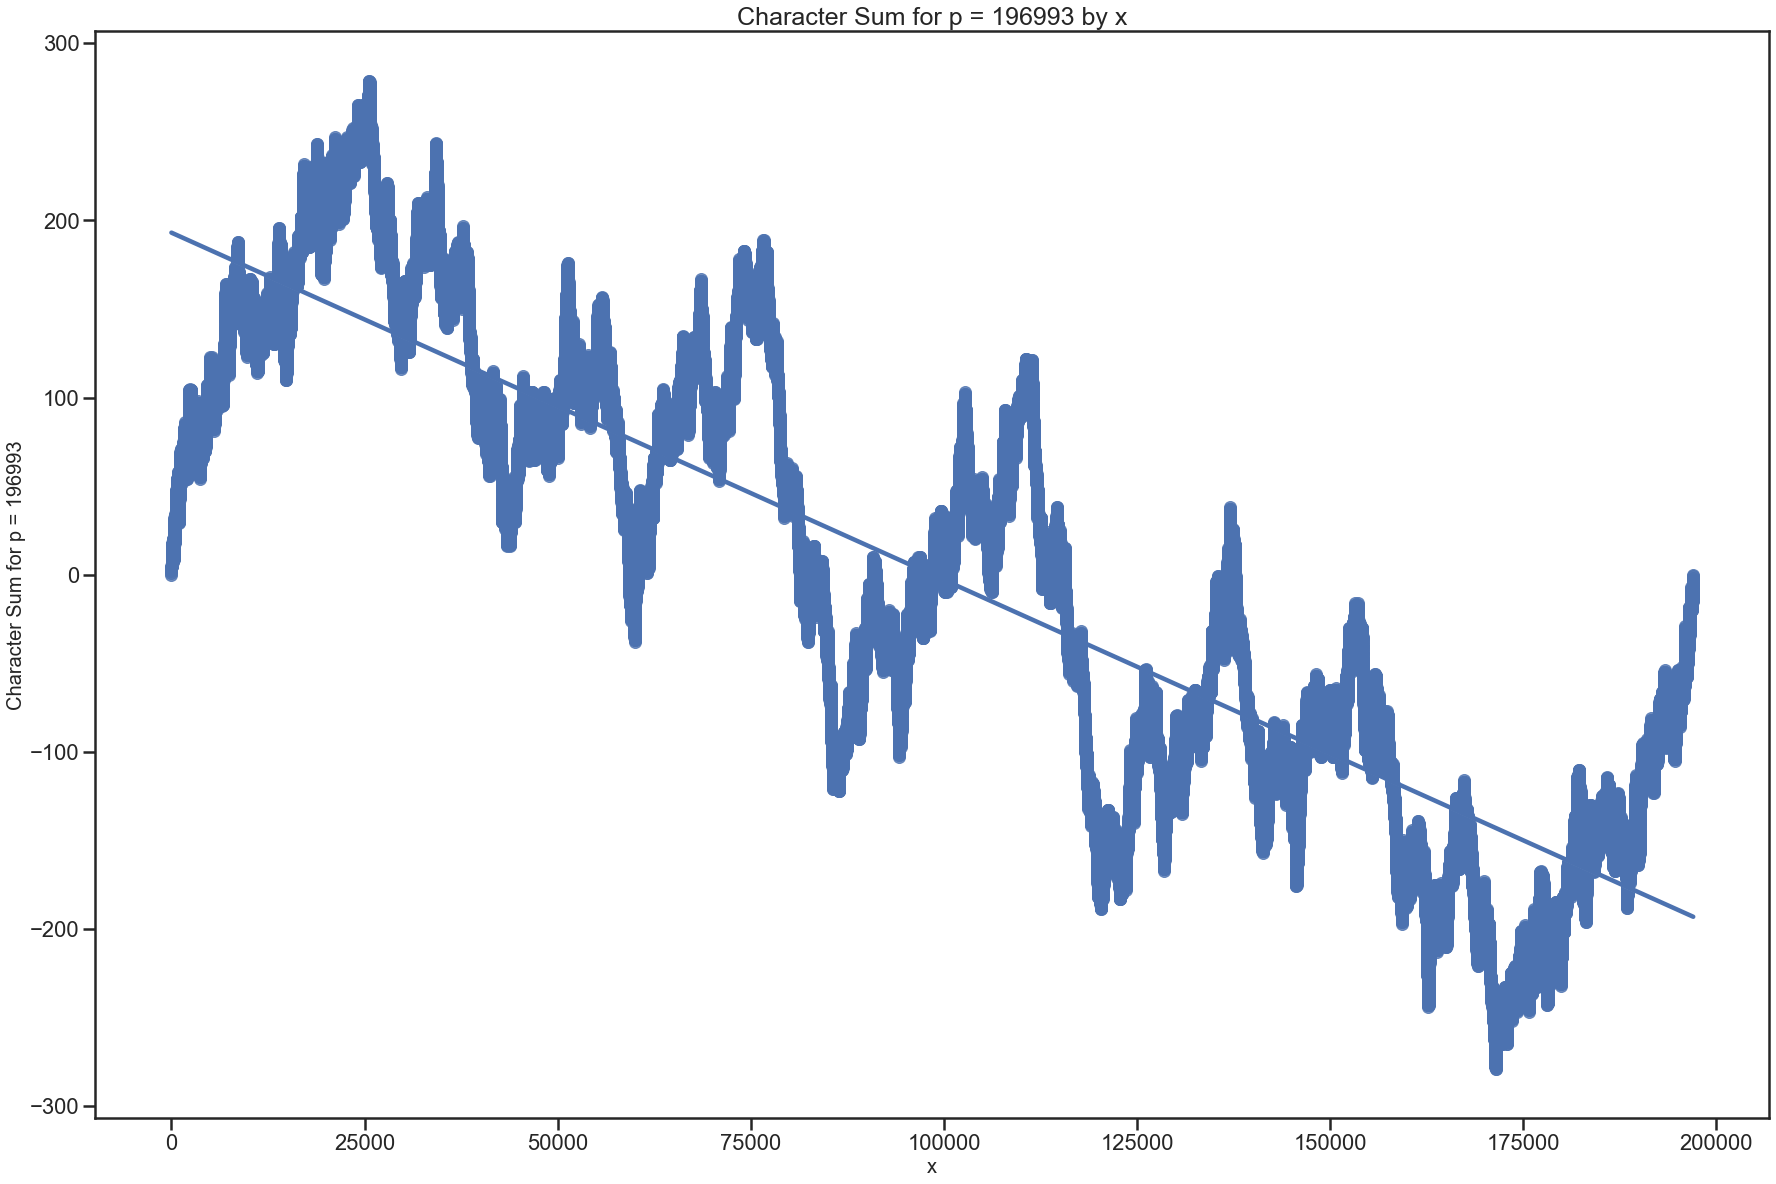

<AxesSubplot:title={'center':'Character Sum for p = 196993 by x'}, xlabel='x', ylabel='Character Sum for p = 196993'>

In [99]:
scatter(list(range(196993)), char_sum_lst, "x", f"Character Sum for p = 196993")

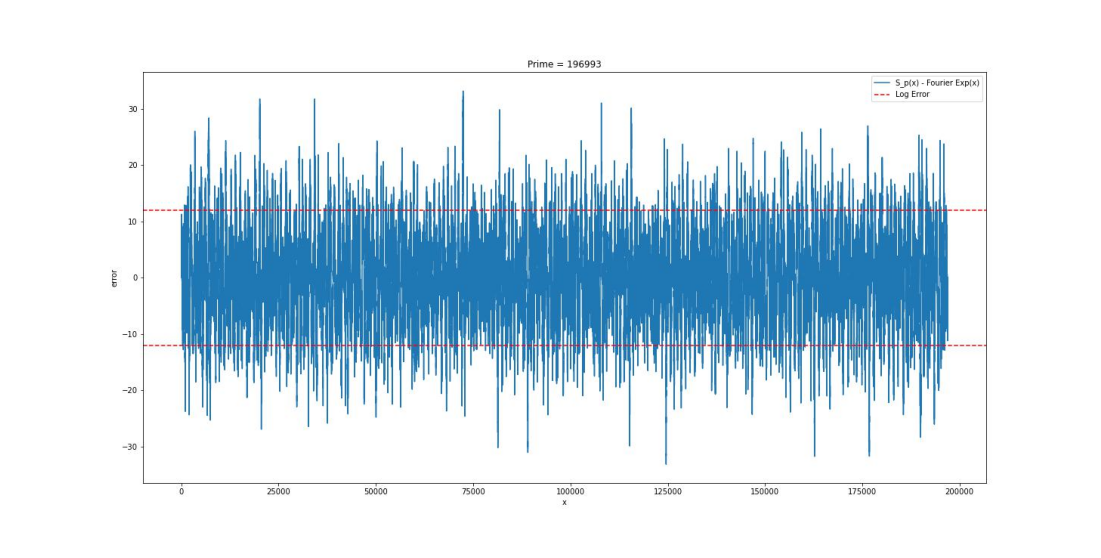

In [97]:
plot('error plots', [(196993)])

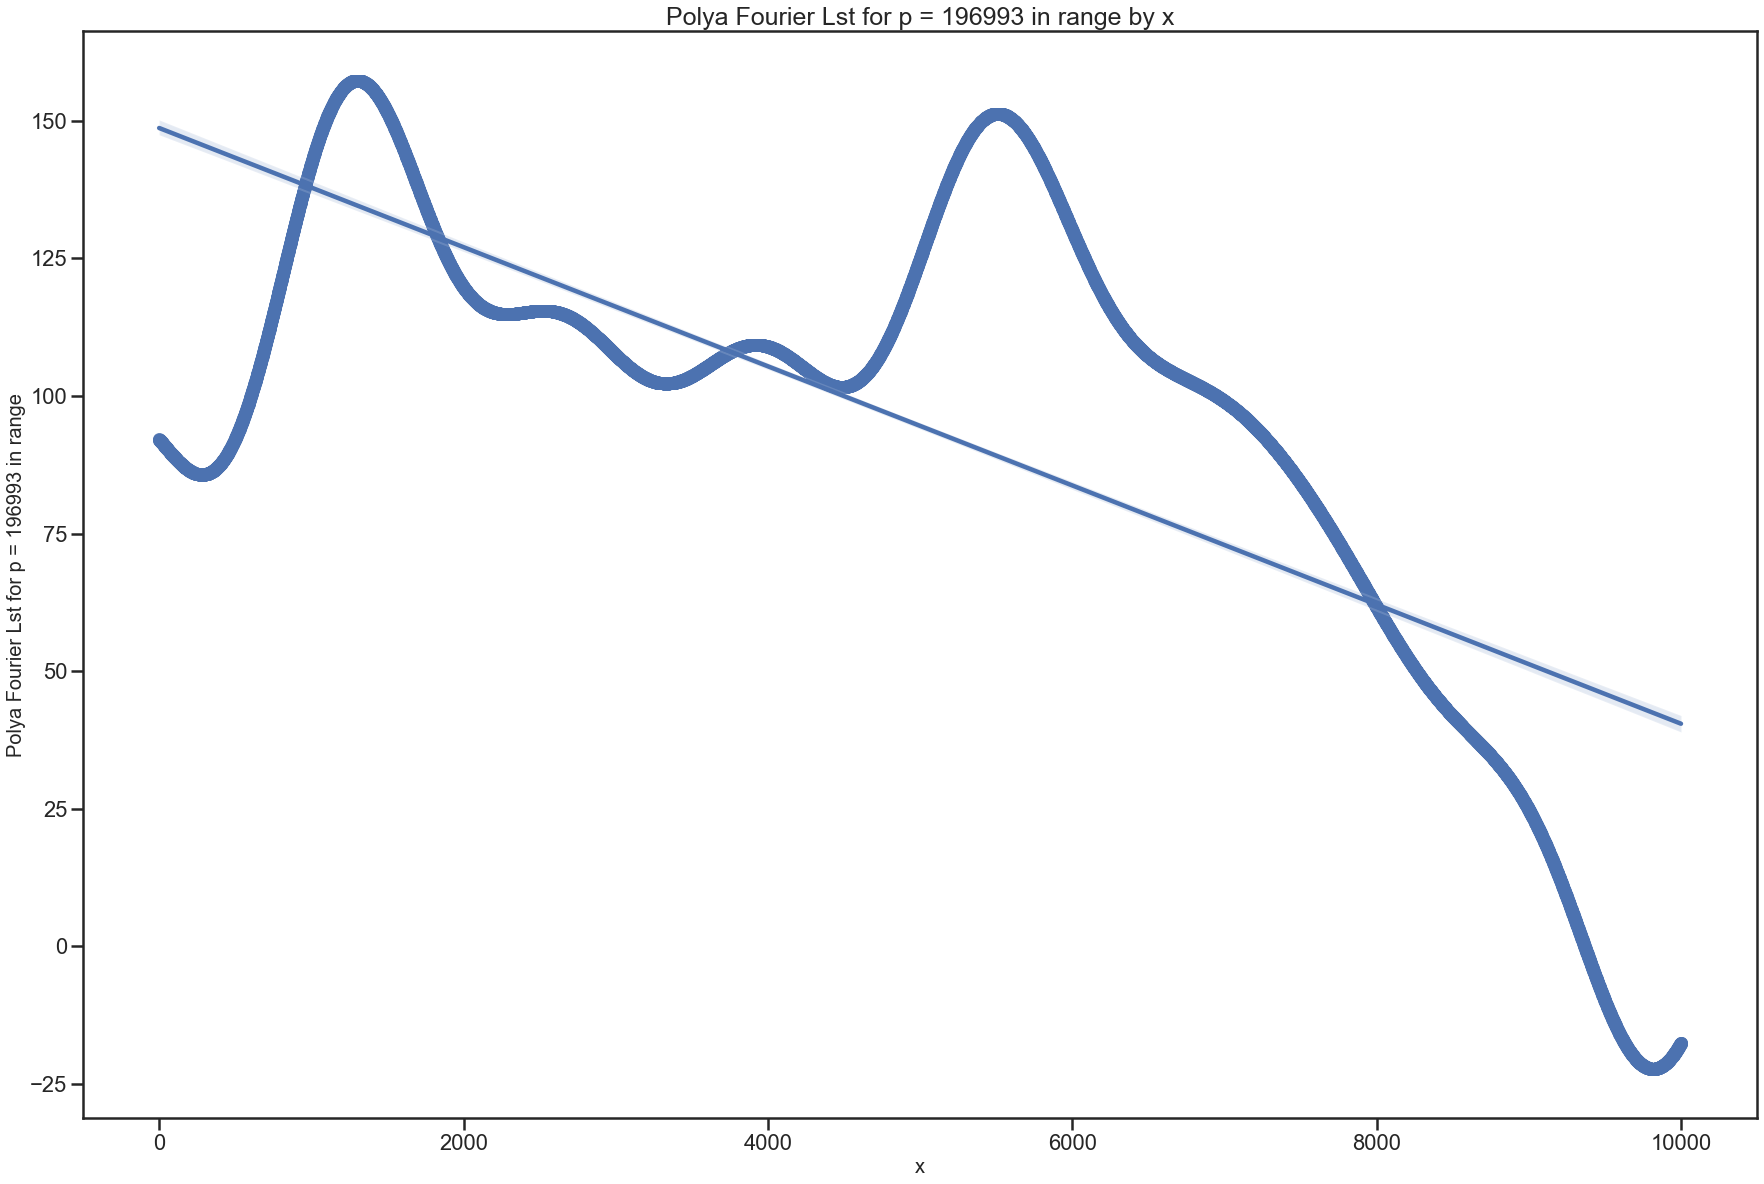

<AxesSubplot:title={'center':'Polya Fourier Lst for p = 196993 in range by x'}, xlabel='x', ylabel='Polya Fourier Lst for p = 196993 in range'>

In [110]:
scatter(list(range(10000)), fourier_lst[50000:60000], "x", f"Polya Fourier Lst for p = 196993 in range")

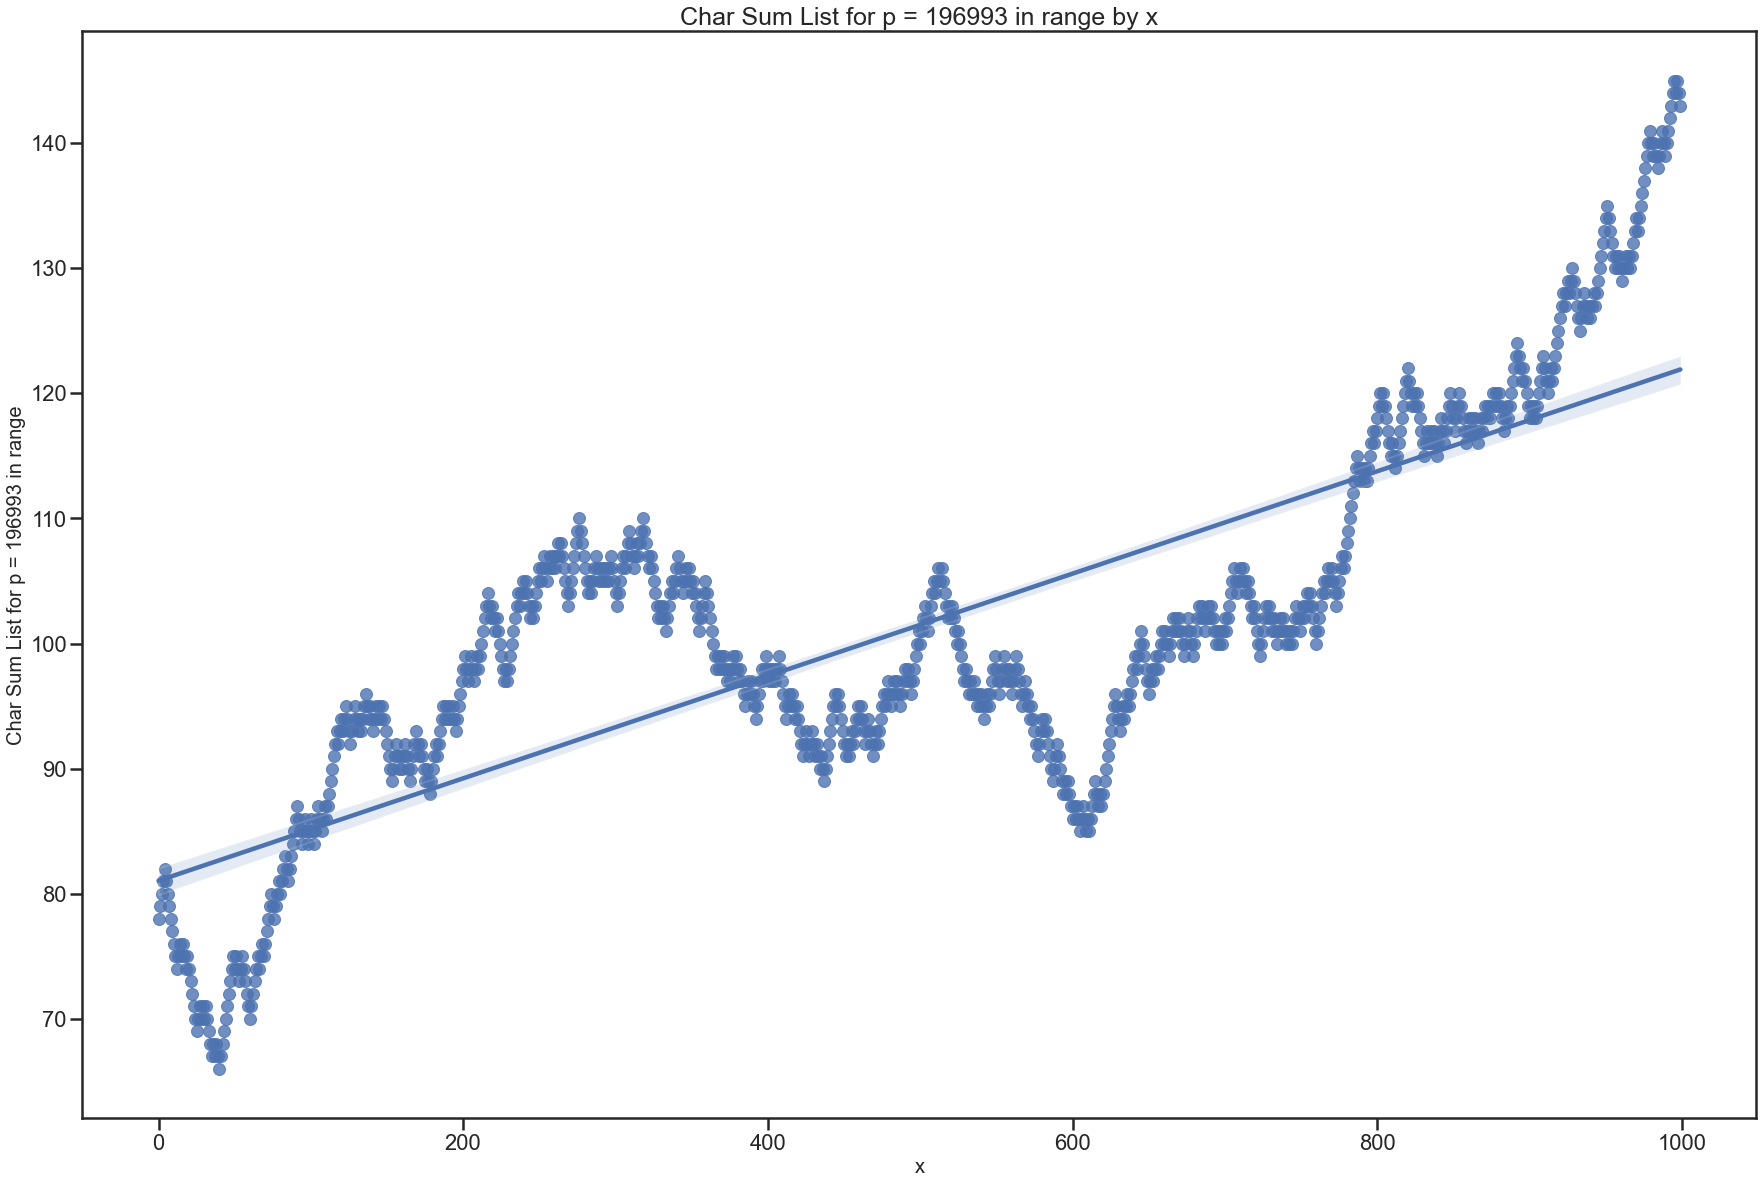

<AxesSubplot:title={'center':'Char Sum List for p = 196993 in range by x'}, xlabel='x', ylabel='Char Sum List for p = 196993 in range'>

In [113]:
scatter(list(range(1000)), char_sum_lst[50000:51000], "x", f"Char Sum List for p = 196993 in range")

### Is Character Sum Brownian Motion?

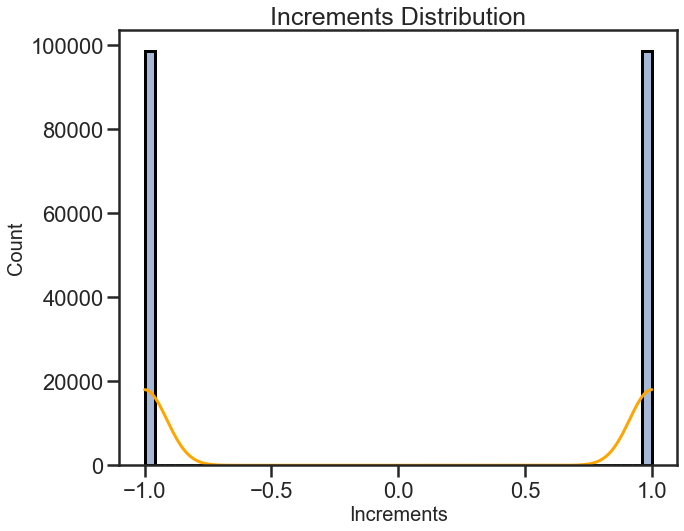

Mean of Increments: 0.0
Standard Deviation of Increments: 1.0


In [107]:
increments = [char_sum_lst[i+1] - char_sum_lst[i] for i in range(196993-1)]
mean_increment = sum(increments) / len(increments)
std_increment = (sum([(incr - mean_increment)**2 for incr in increments]) / len(increments))**0.5

histplot(increments, bins=50, xlabel="Increments")
print(f"Mean of Increments: {mean_increment}")
print(f"Standard Deviation of Increments: {std_increment}")

The argument here would be by Donsker's Invariance Principle. Basically a simple random walk (+/- 1 with equal probability and all independent) converges to brownian motion in the limit (small step and back length). The problem is that each step must be independent and they're not (legendre is multiplicative). Maybe something with only looking at primes but not sure how this argument would play out